In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [2]:
# 读取 .mat 文件
mat_file = r"D:\School work\10-Samples\2025.02.19_DEM+Raingauge+VARI\02.19.mat"
mat_data = scipy.io.loadmat(mat_file)

## 加载并整理输入数据

In [3]:
# 提取特征和标签
X = mat_data['X']  # 特征矩阵，包含高程、坡度、坡向、VARI 和降雨数据
y = mat_data['y']  # 标签，二分类问题，滑坡发生与否（0或1）
is_missing = mat_data['is_missing']  # 异常值指示变量

In [4]:
# 检查数据维度
print(X.shape, y.shape, is_missing.shape)

(20144, 18) (1, 20144) (20144, 18)


In [5]:
# 提取特征
rainfall = X[:, 1:14]  # 过去13天的降雨量数据（Rainfall_2 至 Rainfall_14）
R_today = X[:, 0]      # 当天的降雨量，是降雨数据的第一列（Rainfall_1）
elevation = X[:, 14]   # 高程（第15列）
slope = X[:, 15]       # 坡度（第16列）
aspect = X[:, 16]      # 坡向（第17列）
VARI = X[:, 17]        # VARI（第18列）

In [6]:
# # 查看提取的特征形状
print("降雨数据形状:", rainfall.shape)
print("高程数据形状:", elevation.shape)
print("坡度数据形状:", slope.shape)
print("坡向数据形状:", aspect.shape)
print("VARI数据形状:", VARI.shape)

降雨数据形状: (20144, 13)
高程数据形状: (20144,)
坡度数据形状: (20144,)
坡向数据形状: (20144,)
VARI数据形状: (20144,)


In [7]:
# # 假设土壤湿润度和摩擦力是常数（可以根据需要修改为数据驱动）
# S_moist = 0.5  # 土壤湿润度（假设为常数）
# mu = 0.3  # 摩擦力（假设为常数）
# k = 0.9  # 衰减系数（假设为常数）

In [8]:
# 数据预处理：标准化特征数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 标准化 X 数据

In [9]:
# is_missing 的形状为 (20144, 18)，表示每个特征的缺失指示值
X_train_with_missing = np.hstack([X_scaled, is_missing])
# 结合 `is_missing` 作为额外特征
# 将 is_missing 拼到 X 里

In [10]:
# 扁平化标签，确保其为一维数组
y_train = y.flatten() 

In [11]:
# # 将 `X_train_with_missing` 和 `y_train` 转换为 Tensor 类型
X_train_tensor = torch.tensor(X_train_with_missing, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # 扁平化标签，确保其为一维数组

In [12]:
# # 将 `rainfall`、`slope` 和 `R_today` 转换为 Tensor 类型
rainfall_tensor = torch.tensor(rainfall, dtype=torch.float32)  # 降雨量数据
slope_tensor = torch.tensor(slope, dtype=torch.float32)  # 坡度
R_today_tensor = torch.tensor(R_today, dtype=torch.float32)  # 当天降雨量
VARI_tensor = torch.tensor(VARI, dtype=torch.float32)

In [13]:
# 划分数据集为训练集和测试集（80% 训练，20% 测试）
# X_train, X_test, y_train, y_test = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

In [14]:
# 划分训练集和测试集（70% 训练，30% 测试）
(X_train, X_test, y_train, y_test,
R_train_rainfall, R_test_rainfall,
R_train_today, R_test_today,
slope_train, slope_test,
vari_train, vari_test) = train_test_split(
    X_train_tensor,
    y_train_tensor,
    rainfall_tensor,
    R_today_tensor,
    slope_tensor,
    VARI_tensor,
    test_size=0.99,
    random_state=42
)

## 定义模型

In [15]:
# 定义多层感知机（MLP）模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, dropout_rate=0.1):
        super(MLP, self).__init__()
        
        # 定义网络层
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))  # 输入层
        layers.append(nn.Tanh())  # 激活函数：tanh
        layers.append(nn.Dropout(dropout_rate))  # Dropout层
        
        # 隐藏层
        for _ in range(depth):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # 激活函数：tanh
            layers.append(nn.Dropout(dropout_rate))  # Dropout层
        
        # 输出层
        layers.append(nn.Linear(hidden_size, output_size))  # 输出层（logits）
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.model(x)
        return x  # 在训练时返回 logits

In [16]:
def estimate_soil_moisture(rainfall, R_today, slope, vari, beta=0.8, k_veg=0.5, k_slope=0.01):
    """
    基于指数衰减+简单植被/坡度修正的土壤湿度估计(简化示例)
    不额外增加特征维度，而是在损失函数内部使用。
    """
    powers = torch.arange(rainfall.shape[1], dtype=torch.float32)
    weights = beta ** powers  # [13]
    accum = (rainfall * weights).sum(dim=1)  # [N]
    accum = accum + R_today
    effective_infil = accum * torch.exp(-k_veg * vari)
    slope_rad = slope * np.pi / 180.
    denom = 1.0 + k_slope * torch.tan(slope_rad)
    theta_est = effective_infil / denom
    return theta_est

In [17]:
def moisture_to_risk(theta_est, theta_dry=5.0, theta_sat=50.0):
    """
    将估计含水率映射到滑坡风险(0~1)，线性裁剪示例
    """
    risk = (theta_est - theta_dry) / (theta_sat - theta_dry)
    risk_clamped = torch.clamp(risk, 0.0, 1.0)
    return risk_clamped

In [18]:
def physics_loss_moisture(
    model,
    X_input,
    rainfall,
    R_today,
    slope,
    vari,
    theta_dry=5.0,
    theta_sat=50.0,
    lambda_m=0.1
):
    """
    基于土壤湿度先验的物理损失：
        L_theta = MSE( p_pred , h( theta_est ) )
    """
    # 1) 计算估计含水率
    theta_est = estimate_soil_moisture(rainfall, R_today, slope, vari)

    # 2) 得到物理期望的滑坡概率
    risk_phy = moisture_to_risk(theta_est, theta_dry, theta_sat)  # [N]

    # 3) 获取模型输出并转为概率
    logits = model(X_input)  # [N, 1]
    p_pred = torch.sigmoid(logits).squeeze(-1)  # [N]

    # 4) MSE损失
    loss_m = F.mse_loss(p_pred, risk_phy)
    return lambda_m * loss_m

In [19]:
def total_loss(
    model,
    X_train,
    y_train,
    R,
    R_today,
    slope,
    vari,
    lambda_data=1.0,
    lambda_m=0.1
):
    """
    总损失: 监督损失 + 土壤湿度先验损失
    """
    # 数据损失: 二分类 BCEWithLogits
    criterion = nn.BCEWithLogitsLoss()
    logits = model(X_train)
    data_loss = criterion(logits.squeeze(), y_train)

    # 土壤湿度损失
    moist_loss_val = physics_loss_moisture(
        model=model,
        X_input=X_train,
        rainfall=R,
        R_today=R_today,
        slope=slope,
        vari=vari,
        theta_dry=5.0,
        theta_sat=50.0,
        lambda_m=lambda_m
    )

    # 合并
    loss_total = lambda_data * data_loss + moist_loss_val
    return loss_total

In [20]:
####################################
# (7) 训练函数
####################################

def train(
    model,
    X_train,
    y_train,
    R,
    R_today,
    slope,
    vari,
    epochs=1000,
    lambda_data=0.80,
    lambda_m=0.1
):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_val = total_loss(
            model=model,
            X_train=X_train,
            y_train=y_train,
            R=R,
            R_today=R_today,
            slope=slope,
            vari=vari,
            lambda_data=lambda_data,
            lambda_m=lambda_m
        )
        loss_val.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"{epoch}, {loss_val.item():.6f}")

In [21]:
# 创建多层感知机模型实例
input_size = X_train_with_missing.shape[1]  # 特征数量（包括 is_missing）
hidden_size = 64  # 隐藏层节点数
output_size = 1  # 输出一个预测值
depth = 3  # 隐藏层数量
dropout_rate = 0.1  # Dropout层的丢弃率

# 初始化模型
mlp_model = MLP(input_size, hidden_size, output_size, depth, dropout_rate)

In [22]:
# # 定义优化器，并加入 L2 正则化的 weight_decay
# learning_rate = 1e-3
# lambda_l2 = 0.01  # 设置 L2 正则化强度
# optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [23]:
# 下面这行是使用全部输入数据来训练模型的指令
# train(mlp_model, X_train_with_missing, y.flatten())  # 扁平化 y，确保其是一个一维数组

## 设置训练集和测试集
    后续使用测试集的测试效果反映模型性能

In [24]:
# # 确保所有输入数据是 Tensor 类型
# print(f"X_train type: {type(X_train_with_missing_tensor)}")  # 应该是 <class 'torch.Tensor'>
# print(f"y_train type: {type(y_train)}")  # 应该是 <class 'torch.Tensor'>
# print(f"rainfall type: {type(rainfall)}")  # 应该是 <class 'torch.Tensor'>
# print(f"S_moist type: {type(S_moist)}")  # 应该是 <class 'torch.Tensor'>
# print(f"slope type: {type(slope)}")  # 应该是 <class 'torch.Tensor'>
# print(f"R_today type: {type(R_today)}")  # 应该是 <class 'torch.Tensor'>
# print(f"mu type: {type(mu)}")  # 应该是 <class 'torch.Tensor'>
# print(f"k: {type(k)}")  # 应该是 <class 'torch.Tensor'>

In [25]:
# 训练示例
train(
    model=mlp_model,
    X_train=X_train,
    y_train=y_train,
    R=R_train_rainfall,
    R_today=R_train_today,
    slope=slope_train,
    vari=vari_train,
    epochs=2000,
    lambda_data=0.80,
    lambda_m=0.1
)

0, 0.581211
10, 0.508270
20, 0.369293
30, 0.328915
40, 0.295469
50, 0.294345
60, 0.282032
70, 0.265956
80, 0.260517
90, 0.241463
100, 0.241417
110, 0.226567
120, 0.212414
130, 0.224805
140, 0.228703
150, 0.215816
160, 0.227678
170, 0.199783
180, 0.203165
190, 0.191769
200, 0.193973
210, 0.192984
220, 0.178113
230, 0.180370
240, 0.191459
250, 0.169737
260, 0.162865
270, 0.162653
280, 0.139980
290, 0.154745
300, 0.175662
310, 0.157182
320, 0.137981
330, 0.143972
340, 0.131827
350, 0.132758
360, 0.127877
370, 0.135821
380, 0.111429
390, 0.112279
400, 0.105049
410, 0.115297
420, 0.110286
430, 0.118197
440, 0.104131
450, 0.092907
460, 0.090871
470, 0.098556
480, 0.097023
490, 0.103170
500, 0.097046
510, 0.104002
520, 0.093009
530, 0.094099
540, 0.086247
550, 0.080619
560, 0.086970
570, 0.089003
580, 0.088550
590, 0.086869
600, 0.091051
610, 0.087061
620, 0.077510
630, 0.088393
640, 0.085499
650, 0.077096
660, 0.080639
670, 0.089224
680, 0.077857
690, 0.083714
700, 0.083146
710, 0.077192
720

In [26]:
# 预测并计算不确定性：MC Dropout 预测
def predict_with_uncertainty(model, X, n_samples=100):
    model.train()  # 在训练模式下启用 Dropout
    predictions = np.zeros((n_samples, X.shape[0]))  # 存储每次前向传播的结果
    
    # 多次前向传播获取预测分布
    for i in range(n_samples):
        predictions[i] = model(torch.tensor(X, dtype=torch.float32)).detach().numpy().squeeze()

    # 计算预测的均值和标准差
    mean_prediction = predictions.mean(axis=0)  # 均值
    std_prediction = predictions.std(axis=0)    # 标准差

    return mean_prediction, std_prediction

In [27]:
# 对新样本进行预测并计算不确定性
mean_pred, std_pred = predict_with_uncertainty(mlp_model, X_train_with_missing, n_samples=100)

In [28]:
# 可视化预测结果和不确定性
def plot_uncertainty(mean_pred, std_pred):
    plt.plot(mean_pred, label='Mean Prediction')
    plt.fill_between(range(len(mean_pred)), mean_pred - 2*std_pred, mean_pred + 2*std_pred, color='gray', alpha=0.5)
    plt.legend()
    plt.show()

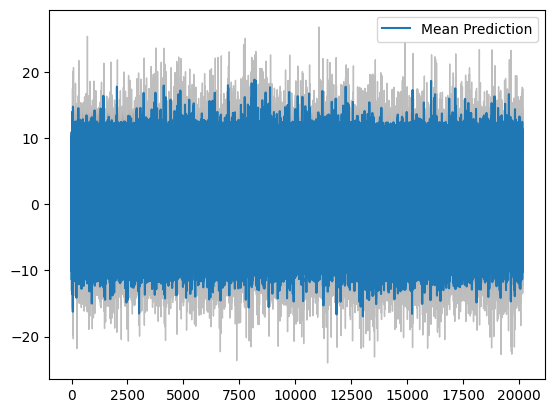

In [29]:
# 可选：可视化模型预测与不确定性
plot_uncertainty(mean_pred, std_pred)

In [30]:
# # 保存训练好的模型
torch.save(mlp_model.state_dict(), '2025.03.23_newPINNs_3.pth')

## 评估模型性能

In [31]:
# 用模型预测测试集
mlp_model.eval()
with torch.no_grad():
    # 如果 X_test 是 Tensor，直接使用它，或者 clone().detach() 来确保不跟计算图相关
    predictions = mlp_model(X_test.clone().detach()).squeeze()  # 使用 clone().detach()
    predictions_classitied = (predictions > 0.5).numpy()  # 将预测结果转化为 0 或 1（分类）

In [32]:
# 计算准确率
accuracy = accuracy_score(y_test, predictions_classitied)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.68%


In [33]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, predictions_classitied)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[7597 2375]
 [2276 7695]]


In [34]:
# 计算精确度与召回率
# 精确度（Precision）：衡量所有被预测为正类的样本中，实际为正类的比例。
# 公式为：Precision = TP / (TP + FP)。
# 召回率（Recall）：衡量所有实际为正类的样本中，模型正确预测为正类的比例。
# 公式为：Recall = TP / (TP + FN)。

precision = precision_score(y_test, predictions_classitied)
recall = recall_score(y_test, predictions_classitied)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.7642
Recall: 0.7717


In [35]:
# F1 分数是精确度和召回率的调和平均数，常用于类不平衡的情况下，衡量模型的综合性能。
# 公式为：F1 = 2 * (Precision * Recall) / (Precision + Recall)。
f1 = f1_score(y_test, predictions_classitied)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7679


In [36]:
# 计算 AUC
# ROC（接收者操作特征）曲线展示了模型在不同分类阈值下的表现。
# AUC（曲线下面积）是该曲线下的面积，值越接近 1，说明模型的表现越好。
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC: {auc_score:.4f}")

AUC: 0.8337


In [37]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [38]:
# 计算 AUC（曲线下面积）
roc_auc = auc(fpr, tpr)

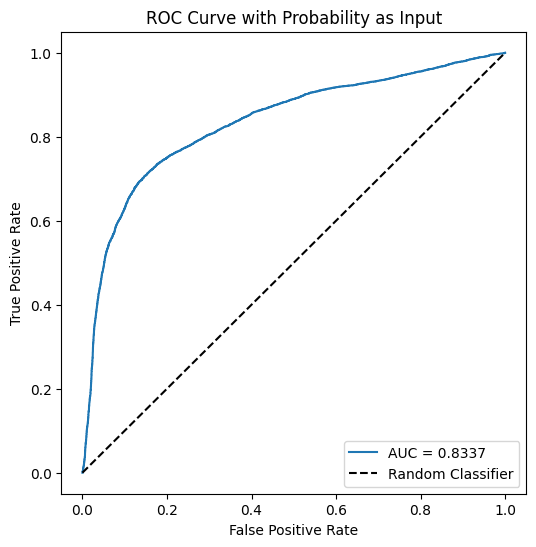

In [39]:
# 绘制 ROC 曲线
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # 随机分类器的对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Probability as Input')
plt.legend(loc='lower right')
plt.show()

In [40]:
# # 对 logits 进行 Sigmoid 激活处理，转换为概率值
# y_pred_prob = torch.sigmoid(y_pred_prob)

# # 打印转换后的概率值
# print(y_pred_prob[:10])  # 查看转换后的概率值

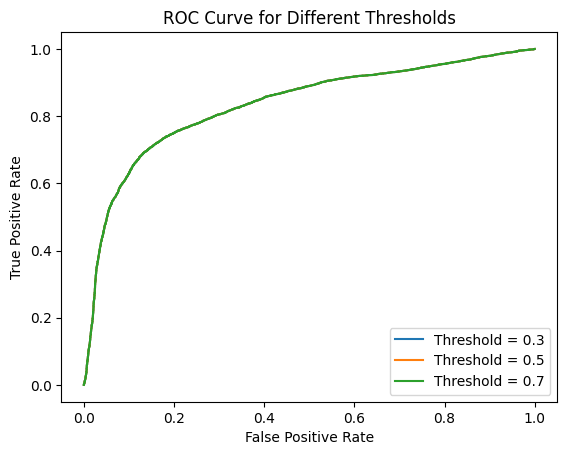

In [41]:
# 手动设置不同的阈值
thresholds = [0.3, 0.5, 0.7]  # 设置不同的阈值

for threshold in thresholds:
    # # 使用 PyTorch 的 .int() 方法进行类型转换
    # y_pred_binary = (predictions > threshold).int()  # 将概率转换为二分类标签
    # 这里将概率转换为二分类标签的做法是错误的，绘制ROC曲线需要直接输入概率值
    
    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(y_test, predictions.numpy())  # 将 Tensor 转为 NumPy 数组
    
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'Threshold = {threshold}')

# 显示 ROC 曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Thresholds')
plt.legend(loc='lower right')
plt.show()
